# <center> Innoscape - Telecom Paristech - Projet fil rouge </center>
# <center> Mapping Groupes de produits </center>

In [1]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.snowball import FrenchStemmer
import re
import random

from Preprocessing_treetagger_v3 import *
from gensim import models, corpora

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

#chemin = "../Data/"
chemin = "C:/Users/JN/Desktop/Telecom ParisTech/Cours/fil_rouge/github/Data/"
chemin_val = "/Users/valentinphetchanpheng/Documents/MS BGD Telecom ParisTech/Projet Fil Rouge/"

C:\Users\JN\Anaconda3\lib\site-packages\treetaggerwrapper.py:740: FutureWarning: Possible nested set at position 8
  re.IGNORECASE | re.VERBOSE)
C:\Users\JN\Anaconda3\lib\site-packages\treetaggerwrapper.py:2044: FutureWarning: Possible nested set at position 152
  re.VERBOSE | re.IGNORECASE)
C:\Users\JN\Anaconda3\lib\site-packages\treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
C:\Users\JN\Anaconda3\lib\site-packages\treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)
C:\Users\JN\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import xgboost as xgb
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Importation des données

In [3]:
# All data set to create embedding
df_total = pd.read_csv('df_total_clean.csv')
df_total = df_total.fillna("")
df_total["concat"] = df_total['productfamily_seller_clean'] + ' ' + \
                     df_total['prodcategory4_seller_clean'] + ' ' + \
                     df_total['prodcategory3_seller_clean'] + ' ' + \
                     df_total['prodcategory2_seller_clean'] + ' ' + \
                     df_total['prodcategory1_seller_clean'] + ' ' + \
                     df_total['productseller_name_clean']

## TF-IDF

In [4]:
# Transformation en tfidf avec la librairie Sklearn
vectorizer = TfidfVectorizer(lowercase=False)
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_total["concat"]))
tfidf_feature_names = vectorizer.get_feature_names()

## Embedding

In [ ]:
nmf = NMF(n_components=200, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total)

In [5]:
from sklearn.externals import joblib

#joblib.dump(nmf, "nmf_200topics_base.save") 
nmf = joblib.load("nmf_200topics_base.save") 

### Importation des labels et transformation

In [39]:
X = pd.DataFrame(nmf.transform(tf_idf_total)).set_index(df_total.index.values)
labels = pd.read_excel("df_train-4.xlsx").set_index('Index')
labels_dict = dict(enumerate(labels['Product_family_innoscape'].unique()))
reverse_dict = dict(zip(labels_dict.values(),labels_dict.keys()))
X_labelled = X.loc[labels.index.values]
unlabelled_idx = [i for i in X.index.values if i not in labels.index.values]
X_unlabelled = X.loc[unlabelled_idx]
Y = labels['Product_family_innoscape'].apply(lambda x: reverse_dict[x])

### Premier modèle

#### Accuracy

In [8]:
clf_ex = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
scores = cross_val_score(clf_ex, X_labelled, Y, cv=10) 
print(scores, np.mean(scores))

C:\Users\JN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.66081871 0.74096386 0.74922601 0.74763407 0.79411765 0.8440678
 0.86572438 0.88321168 0.86692015 0.77380952] 0.792649382449189


#### Matrice de confusion

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

n_fam = len(list(labels_dict.keys()))
conf_matrix = np.zeros((n_fam, n_fam))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_labelled):
    X_train, X_test = X_labelled.iloc[train_index], X_labelled.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf_ex.fit(X_train, y_train)
    y_pred = clf_ex.predict(X_test)
    conf_matrix += confusion_matrix(y_test, y_pred, labels=list(labels_dict.keys()))

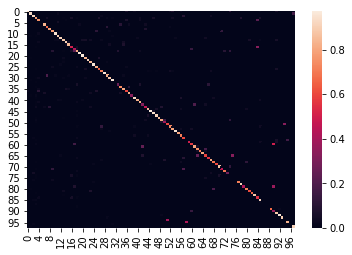

In [12]:
conf_matrix = pd.DataFrame(conf_matrix, index = list(labels_dict.keys()))
totals_true = np.sum(conf_matrix, axis=1)
totals_pred = np.sum(conf_matrix, axis=0)
sns.heatmap(conf_matrix/(totals_true+1))

#### Recall, precision, f1 par famille

In [15]:
recalls = [conf_matrix.loc[i,i]/totals_true[i] for i in range(len(totals_true))]
precisions = [conf_matrix.loc[i,i]/(totals_pred[i]+1) for i in range(len(totals_true))]
scores = pd.DataFrame(list(labels_dict.values()),index=list(labels_dict.keys()))
scores["effectifs"]=totals_true
scores["recall"]=recalls
scores['precision']=precisions
scores['f1']=2*scores.precision*scores.recall/(scores.precision+scores.recall)
scores.sort_values(['f1'],ascending=False).head(100)

0  effectifs    recall  \
28                                          Chauffage       22.0  1.000000   
19                                    Chauffe-eau gaz       33.0  1.000000   
45                 Gouttière, descente et accessoires       94.0  0.978723   
92                             Meuleuse et rainureuse       47.0  0.978723   
54        Grillage avertisseur et gaine de protection       40.0  0.975000   
24                                    Aérateur et VMC       48.0  0.979167   
31    Tondeuses electriques, thermiques et autoportée       59.0  0.983051   
22          Perceuse, perforateur et visseuse filaire       23.0  0.956522   
10              Tronçonneuse, scie et fendeur de bois       44.0  0.977273   
20                                Ponceuse électrique       39.0  1.000000   
93                       Motobineuses et motoculteurs       19.0  0.947368   
83                             Outillage stationnaire       16.0  0.937500   
1          Perceuse, perforateur et visseuse sans fil       90.0  0.944444   
12                                   Ampoules et leds       47.0  0.936170   
48                                     Clé et douille       19.0  0.894737   
39  Poudre béton, chaux, ciment, enduit, mortier, ...       96.0  0.937500   
47                                         Couverture       66.0  0.924242   
78                                        Adoucisseur       11.0  1.000000   
46                            Vidage, bonde et siphon       16.0  1.000000   
2                                            Arrosage       62.0  0.935484   
70                                            Ombrage       15.0  0.933333   
0                           Mastic, colle, étanchéité      329.0  0.945289   
14                                       Taille-haies       74.0  0.918919   
30                 Débroussailleuse et coupe-bordures       48.0  0.895833   
40                                         Divers OEP       34.0  0.852941   
64                                 Sol PVC en rouleau        4.0  1.000000   
11                               Batterie et chargeur       39.0  0.923077   
55                    Barre de seuil et nez de marche        4.0  1.000000   
97     Tournevis (cruciforme, aimanté, de précision…)       22.0  0.954545   
15                Accessoires pour outillage motorisé       60.0  0.866667   
..                                                ...        ...       ...   
36                      Pistolet à colle et agrafeuse       41.0  0.609756   
66                Carré potager et table de rempotage        8.0  0.625000   
59                                       Lime et râpe        7.0  0.571429   
65  Accessoires du tableau électrique (bornier, pe...       21.0  0.619048   
60               Accessoires et divers outils peintre       20.0  0.600000   
57                                    Abris de jardin        9.0  0.666667   
51                                            Marteau        4.0  0.750000   
79                               Outillage du peintre       13.0  0.461538   
71                                 Mobilier de jardin       14.0  0.500000   
16                           Produits phytosanitaires       17.0  0.529412   
43                            Accessoires d'isolation       25.0  0.480000   
84        Accessoires pour outillage à main de jardin        8.0  0.625000   
38                        Compresseurs et accessoires        5.0  0.400000   
50                                        Anti-mousse       12.0  0.416667   
73                           Nettoyeur haute pression        6.0  0.333333   
17                            Protection du jardinier       11.0  0.454545   
33                    Semence, engrais, rouleau gazon       10.0  0.300000   
42                         Disjoncteur de branchement       11.0  0.363636   
90                        Produits et traitement bois        7.0  0.428571   
5                              Outillage du carreleur        2.0  0.000000

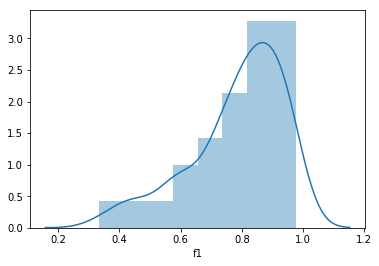

In [17]:
sns.distplot(scores.f1.dropna())

In [18]:
weak_scores = scores[scores['f1']<0.75]
weak_scores.shape

(29, 5)

In [19]:
strong_scores = scores[scores['f1']>=0.75]
strong_scores.shape

(58, 5)

In [20]:
nans = scores[scores['f1'].isnull()]
nans.shape

(11, 5)

## Etude des prédictions sur le dataset non étiqueté

In [22]:
clf_ex = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
clf_ex.fit(X_labelled, Y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=100, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [24]:
pred_probas = pd.DataFrame(clf_ex.predict_proba(X_unlabelled), index=X_unlabelled.index)
pred_probas['predicted_fam'] = pred_probas.apply(lambda row: np.argmax(row), axis=1)
pred_probas['proba'] = pred_probas.apply(lambda row: row[int(row['predicted_fam'])], axis=1)
results = pd.concat([df_total.loc[X_unlabelled.index], pred_probas[['predicted_fam','proba']]],axis=1, join='inner' )
results['pred_fam_name']=results['predicted_fam'].apply(lambda x: labels_dict[x])

C:\Users\JN\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [ ]:
#results.to_csv('predictions1.csv', index=True, encoding='utf-8')

Voyons dans quelle mesure les prédictions associées à une forte probabilité sont fiables:

In [25]:
high_proba = results[results['proba']>=0.75]
high_proba.head()

Unnamed: 0 productfamily_seller prodcategory4_seller  \
40          40        Scies égoïnes                Scies   
64          64   Colles à carrelage   Colles à carrelage   
67          67                                             
68          68   Colles à carrelage   Colles à carrelage   
81          81                                             

         prodcategory3_seller                 prodcategory2_seller  \
40  Outillage électroportatif  Outillage à main et électroportatif   
64         Colles et adhésifs                        Quincaillerie   
67         Colles et adhésifs                        Quincaillerie   
68         Colles et adhésifs                        Quincaillerie   
81         Colles et adhésifs                        Quincaillerie   

   prodcategory1_seller                                 productseller_name  \
40            Bricolage  AEG ST 800 XE Orange Scie Sauteuse Sciage 110m...   
64            Bricolage  SikaCeram Joint Fin   Mortier joint de carrela...   
67            Bricolage            Colle mastic multi usage spécial marine   
68            Bricolage       SikaCeram Joint   Mortier joint de carrelage   
81            Bricolage  Mastic Colle Spécial Bateaux   Sikaflex Marine...   

   productfamily_seller_clean prodcategory4_seller_clean  \
40                egoine scie                       scie   
64            colle carrelage            colle carrelage   
67                                                         
68            colle carrelage            colle carrelage   
81                                                         

   prodcategory3_seller_clean      prodcategory2_seller_clean  \
40  outillage electroportatif  outillage electroportatif main   
64              colle adhesif                   quincaillerie   
67              colle adhesif                   quincaillerie   
68              colle adhesif                   quincaillerie   
81              colle adhesif                   quincaillerie   

   prodcategory1_seller_clean  \
40                  bricolage   
64                  bricolage   
67                  bricolage   
68                  bricolage   
81                  bricolage   

                            productseller_name_clean  \
40              sciage scier orange sauteur|sauteuse   
64  blanc fin joindre mortier cgwa largeur carrelage   
67            marin usage colle multi mastic special   
68                         mortier joindre carrelage   
81       sikaflex marin bateau coller mastic special   

                                               concat  predicted_fam  \
40  egoine scie scie outillage electroportatif out...             21   
64  colle carrelage colle carrelage colle adhesif ...              0   
67    colle adhesif quincaillerie bricolage marin ...              0   
68  colle carrelage colle carrelage colle adhesif ...              0   
81    colle adhesif quincaillerie bricolage sikafl...              0   

       proba              pred_fam_name  
40  0.819255          Scies électriques  
64  0.951091  Mastic, colle, étanchéité  
67  0.774000  Mastic, colle, étanchéité  
68  0.934411  Mastic, colle, étanchéité  
81  0.767000  Mastic, colle, étanchéité

Voyons également comment les prédictions se répartissent entre les familles:

C:\Users\JN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


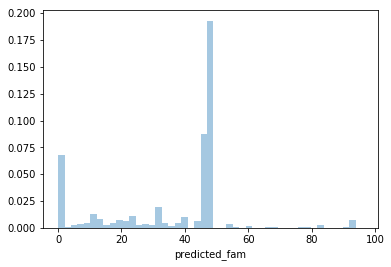

In [26]:
sns.distplot(high_proba.predicted_fam, kde=False, norm_hist=True)

In [219]:
high_proba.groupby('pred_fam_name').count()['predicted_fam'].sort_values(ascending=False)

pred_fam_name
Couverture                                                 5020
Gouttière, descente et accessoires                         2183
Mastic, colle, étanchéité                                  1425
Tondeuses electriques, thermiques et autoportée             492
Perceuse, perforateur et visseuse sans fil                  404
Batterie et chargeur                                        324
Poudre béton, chaux, ciment, enduit, mortier, ragréage      253
Aérateur et VMC                                             233
Meuleuse et rainureuse                                      186
Ponceuse électrique                                         160
Accessoires couverture                                      157
Protection jardin, paillage, tuteurs et accessoires         153
Produits et traitement bois                                 151
Perceuse, perforateur et visseuse filaire                   146
Chauffe-eau électrique                                      122
Chauffe-eau thermodynamiqu

## Intégration des prédictions associées aux probabilités les plus élevées aux données labellisées

On a intégré les prédictions du modèle au dataset étiqueté de la manière suivante:
    - les produits affectés aux catégories pour lesquelles le score f1 du modèle précédent était élevé (>0.8) sont ajoutés au dataset
    - les produits affectés aux autres catégories sont ajoutés si la probabilité donnée par le modèle précédent est supérieure à 0.5
    - pour ces dernières catégories, une vérification manuelle des prédictions a été effectuée, de manière notamment à corriger les biais causés par les faibles effectifs de ceraines familles dans le train set

In [27]:
new_labels = pd.read_excel('predictions1_revu.xlsx').set_index("Index")
new_labels.drop('predicted_fam', axis=1,inplace=True)

new_labels = new_labels[new_labels['A retirer']==0]

#on sépare les prédictions affectées aux catégories fiables des autres prédictions
new_labels_strong_scores = new_labels[new_labels['Product_family_innoscape'].isin(strong_scores[0].unique())]
new_labels_strong_scores = new_labels_strong_scores[new_labels_strong_scores['proba']>0.75]

new_labels_weak_scores = new_labels[new_labels['Product_family_innoscape'].isin(weak_scores[0].unique())]
new_labels_weak_scores = new_labels_weak_scores[new_labels_weak_scores['proba']>0.5]

#on rassemble tous les nouveaux labels
new_labels2 = pd.concat([new_labels_strong_scores,new_labels_weak_scores], axis=0)

new_labels2.shape

(13053, 3)

In [29]:
Y_2 = new_labels2['Product_family_innoscape'].apply(lambda x: reverse_dict[x])
Y_3 = pd.concat([Y,Y_2],axis=0)
X_labelled_3 = X.loc[Y_3.index]
X_labelled_3.shape

On peut à présent ré-entraîner le modèle avec davantage de données:

In [31]:
clf_ex3 = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
scores = cross_val_score(clf_ex3, X_labelled_3, Y_3, cv=10)
print(scores, np.mean(scores))

C:\Users\JN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.88828172 0.91426822 0.94944513 0.96408669 0.96956522 0.970625
 0.98180678 0.98738966 0.98856417 0.98845414] 0.9602486716440175


#### Matrice de confusion

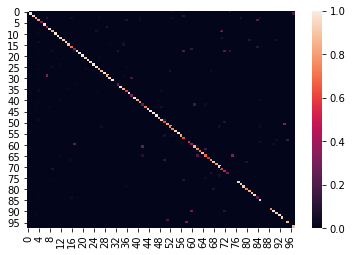

In [32]:
conf_matrix = np.zeros((n_fam, n_fam))

for train_index, test_index in kf.split(X_labelled_3):
    X_train, X_test = X_labelled_3.iloc[train_index], X_labelled_3.iloc[test_index]
    y_train, y_test = Y_3.iloc[train_index], Y_3.iloc[test_index]
    clf_ex = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)  
    clf_ex.fit(X_train, y_train)
    y_pred = clf_ex.predict(X_test)
    conf_matrix += confusion_matrix(y_test, y_pred, labels=list(labels_dict.keys()))

conf_matrix = pd.DataFrame(conf_matrix, index = list(labels_dict.keys()))
totals_true = np.sum(conf_matrix, axis=1)
totals_pred = np.sum(conf_matrix, axis=0)
sns.heatmap(conf_matrix/(totals_true+1))

In [33]:
recalls = [conf_matrix.loc[i,i]/totals_true[i] for i in range(len(totals_true))]
precisions = [conf_matrix.loc[i,i]/(totals_pred[i]+1) for i in range(len(totals_true))]
scores = pd.DataFrame(list(labels_dict.values()),index=list(labels_dict.keys()))
scores["effectifs"]=totals_true
scores["recall"]=recalls
scores['precision']=precisions
scores['f1']=2*scores.precision*scores.recall/(scores.precision+scores.recall)
scores.sort_values(['f1'],ascending=False).head(100)

0  effectifs    recall  \
47                                         Couverture     5086.0  0.999803   
45                 Gouttière, descente et accessoires     2277.0  1.000000   
46                            Vidage, bonde et siphon      109.0  1.000000   
31    Tondeuses electriques, thermiques et autoportée      492.0  0.997967   
24                                    Aérateur et VMC      281.0  0.996441   
55                    Barre de seuil et nez de marche       60.0  1.000000   
19                                    Chauffe-eau gaz       52.0  1.000000   
37                             Chauffe-eau électrique      150.0  0.993333   
20                                Ponceuse électrique      198.0  1.000000   
10              Tronçonneuse, scie et fendeur de bois      149.0  0.993289   
22          Perceuse, perforateur et visseuse filaire      147.0  0.986395   
11                               Batterie et chargeur      363.0  0.991736   
34                        Chauffe-eau thermodynamique      118.0  0.983051   
92                             Meuleuse et rainureuse      233.0  0.982833   
28                                          Chauffage       36.0  1.000000   
6                             Accessoires chauffe-eau      101.0  0.990099   
1          Perceuse, perforateur et visseuse sans fil      480.0  0.987500   
8                   Conduit et accessoires d'aération       87.0  1.000000   
0                           Mastic, colle, étanchéité     1753.0  0.994295   
39  Poudre béton, chaux, ciment, enduit, mortier, ...      325.0  0.984615   
44                             Accessoires couverture      215.0  0.967442   
77  Purificateur, déshumidificateur et humidificateur       38.0  0.973684   
83                             Outillage stationnaire       71.0  0.985915   
93                       Motobineuses et motoculteurs       26.0  0.961538   
30                 Débroussailleuse et coupe-bordures      109.0  0.963303   
54        Grillage avertisseur et gaine de protection       42.0  0.952381   
90                        Produits et traitement bois      299.0  0.969900   
82                  Défonceuse et lamelleuse et rabot       19.0  0.947368   
23                              Outils multifonctions       86.0  0.953488   
64                                 Sol PVC en rouleau        8.0  1.000000   
..                                                ...        ...       ...   
53                                           Peinture       48.0  0.770833   
16                           Produits phytosanitaires       21.0  0.714286   
62     Tableau électrique et coffret de communication       19.0  0.789474   
66                Carré potager et table de rempotage        8.0  0.625000   
59                                       Lime et râpe        8.0  0.625000   
65  Accessoires du tableau électrique (bornier, pe...       24.0  0.708333   
36                      Pistolet à colle et agrafeuse       50.0  0.600000   
71                                 Mobilier de jardin       14.0  0.642857   
50                                        Anti-mousse       14.0  0.642857   
57                                    Abris de jardin        9.0  0.666667   
72              Produits et traitement bois intérieur        9.0  0.555556   
7           Aspirateurs, nettoyeurs HP et accessoires       21.0  0.523810   
5                              Outillage du carreleur        2.0  0.500000   
38                        Compresseurs et accessoires        5.0  0.400000   
60               Accessoires et divers outils peintre       29.0  0.413793   
73                           Nettoyeur haute pression        6.0  0.333333   
33                    Semence, engrais, rouleau gazon       10.0  0.300000   
17                            Protection du jardinier       11.0  0.363636   
42                         Disjoncteur de branchement       11.0  0.272727   
84        Accessoires pour outillage à main de jardin        8.0  0.250000

C:\Users\JN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


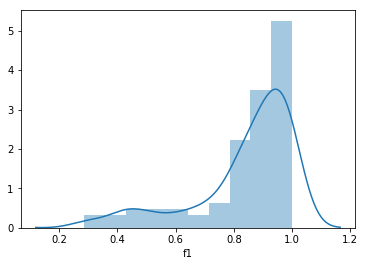

In [38]:
sns.distplot(scores.f1.dropna())

In [34]:
strong_scores = scores[scores['f1']>=0.90].sort_values(['f1'],ascending=False)
strong_scores.shape

(46, 5)

In [36]:
weak_scores2 = scores[scores['f1']<0.90].sort_values(['f1'],ascending=False)
weak_scores2.shape

(42, 5)

In [37]:
nans = scores[scores['f1'].isnull()]
nans.shape

(10, 5)